In [1]:
'''
k-correction demonstrator.
'''

'\nk-correction demonstrator.\n'

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import k_corrections as kc
import catalogue_analysis as ca
from   astropy.table import Table, vstack

In [3]:
# load in BGS Y1 catalogue, restrict to 0.002<z<0.6

survey = 'Y1'
fpathN = '/pscratch/sd/a/amjsmith/Y1/LSS/iron/LSScats/v0.5/BGS_BRIGHT_N_clustering.dat.fits'
fpathS = '/pscratch/sd/a/amjsmith/Y1/LSS/iron/LSScats/v0.5/BGS_BRIGHT_S_clustering.dat.fits'
dat = kc.load_catalogues(fpathN, fpathS)

reg = 'N' # redshift limits same for N and S.
min_z_val = kc.selection(reg)['zmin']
max_z_val = kc.selection(reg)['zmax']

zmask = (dat['Z'] > min_z_val) & (dat['Z'] < max_z_val)
mask = zmask
dat = dat[mask]

/global/u2/l/ldrm11/Cole/kcorr_code/k_corrections.py:64: RuntimeWarning: divide by zero encountered in log10
  dat.add_column(Column(name='zmag', data=22.5-2.5*np.log10(dat['flux_z_dered'])))


starting region  N
band1: R band2: G
nx,ny: 239 199
LOADING IN LOOKUP TABLE.
opath: /global/homes/l/ldrm11/Cole/data/H_N.txt
colvar: gmr_obs
-2.718914 3.7602654


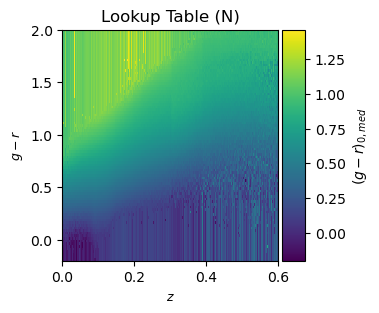

colvar: gmr_obs
REST-FRAME COLOURS ASSIGNED.
starting region  S
band1: R band2: G
nx,ny: 239 199
LOADING IN LOOKUP TABLE.
opath: /global/homes/l/ldrm11/Cole/data/H_S.txt
colvar: gmr_obs
-2.718914 3.7602654


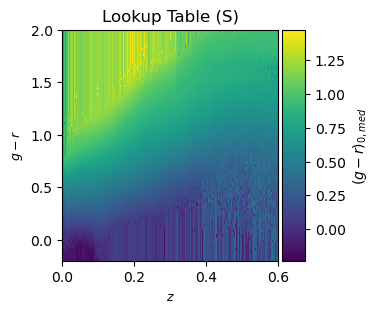

colvar: gmr_obs
REST-FRAME COLOURS ASSIGNED.


In [18]:
# this function generates and uses a colour-lookup table based on FSF data.
# NB: set up here to use fresh = False (as k-corr polynomial files provided.)

fresh = False
regions = ['N', 'S']

dat['REST_GMR_0P1_Cole'] = -99.9
dat['XBIN'] = 0
dat['YBIN'] = 0
ca.recompute_rest_col_mag(dat,regions, fresh=fresh)

In [19]:
# example usage of k-correction function.

dat['K_R'] = -99.9

for reg in regions:
    regmask = (dat['reg'] == reg)
    kcorr_r  = kc.DESI_KCorrection(band='R', file='jmext', photsys=reg)
    
    dat['K_R'][regmask] = kcorr_r.k(dat['Z'][regmask], dat['REST_GMR_0P1'][regmask])

In [20]:
def plot_kcorr(regions):
    # extract the default colour sequence to have more control of line colors
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    for reg in regions:
        # set up the k-corrections for this photometry system region
        kcorr_r  = kc.DESI_KCorrection(band='R', file='jmext', photsys=reg)
        Sel=kc.selection(reg) # define selection parameters for this region
        z=np.linspace(0.0,0.6,300)
        icol=-1
        #for rest_GMR in np.array([0.39861393, 0.53434181, 0.6534462 , 0.76661587, 0.86391068,
       #0.93073082, 0.9832058 ]): #
            
        for rest_GMR in np.linspace(0.0,1.1,8):   
            GMR=rest_GMR*np.ones(z.size)
            icol += 1
            k=kcorr_r.k(z, GMR)
            label=reg+': G-R='+np.array2string(rest_GMR)
            plt.plot(z,k,label=label,color=colors[icol],linestyle=Sel['style']) 
    plt.xlabel('$z$')    
    plt.ylabel('$k^r(z)$')  
    plt.legend(loc=(1.04,0))
    
    plt.show()

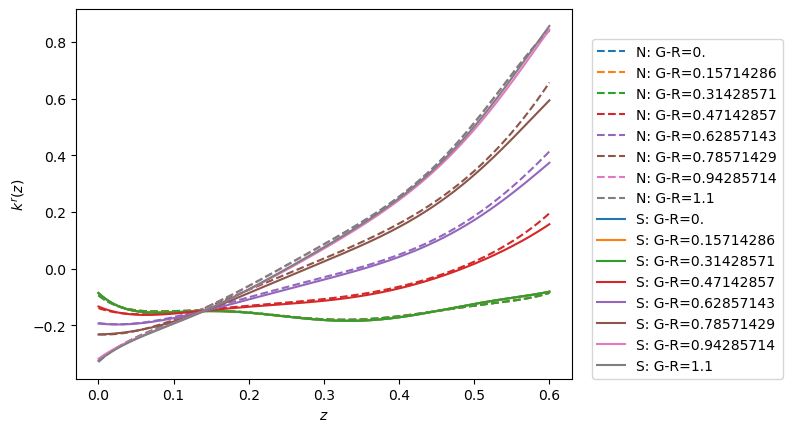

In [21]:
plot_kcorr(regions)

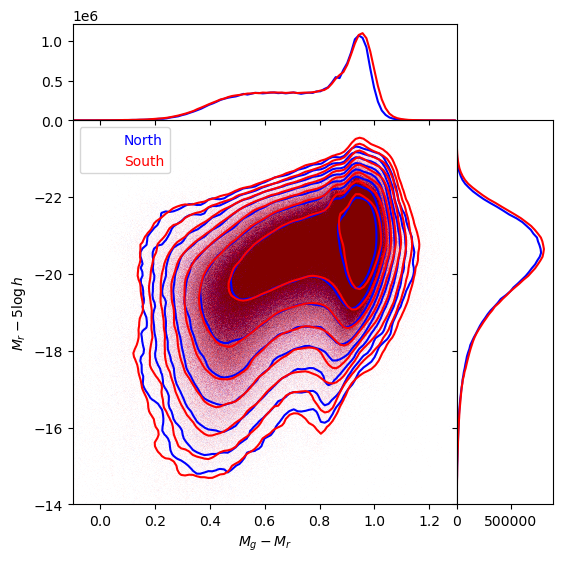

In [22]:
ca.plot_col_mag(dat,regions)

In [23]:
# load in John Moustakas FSF data for comparison.
fpath = '/pscratch/sd/l/ldrm11/fastspecfit-iron-main-bright.fits'
fsf   = Table.read(fpath)

fsf['REST_GMR_0P1'] = fsf['ABSMAG_SDSS_G'] - fsf['ABSMAG_SDSS_R']

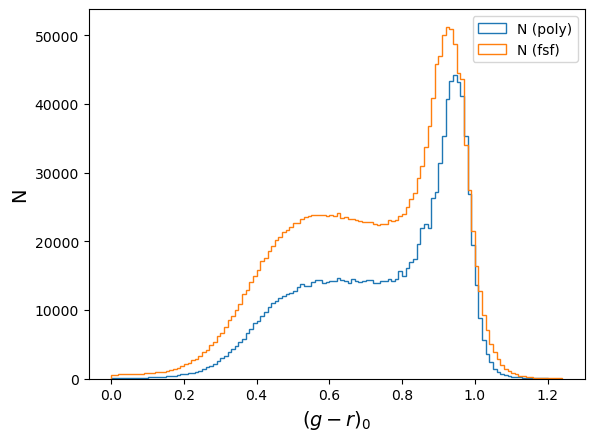

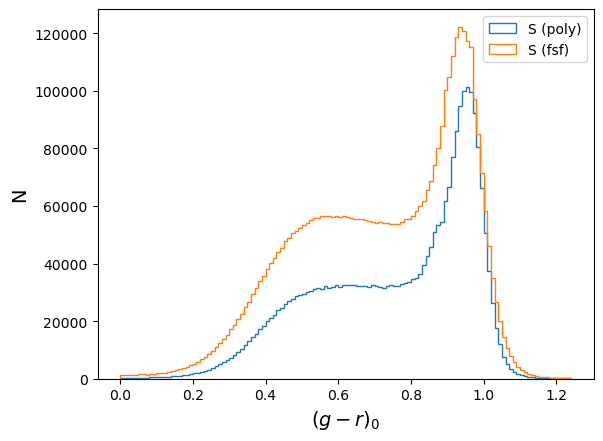

In [24]:
bins = np.arange(0, 1.25, 0.01)

for reg in regions:
    fsfmask = (fsf['PHOTSYS'] == reg)
    datmask = (dat['reg'] == reg)

    plt.hist(dat[datmask]['REST_GMR_0P1'], bins=bins, histtype='step', label='{} (poly)'.format(reg))
    plt.hist(fsf[fsfmask]['REST_GMR_0P1'], bins=bins, histtype='step', label='{} (fsf)'.format(reg))
    
    plt.xlabel(r'$(g-r)_0$', fontsize=14)
    plt.ylabel(r'N', fontsize=14)
    plt.legend()
    plt.show()

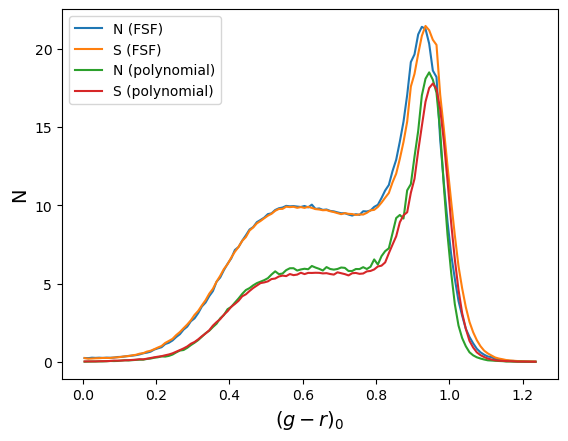

In [25]:
bins = np.arange(0.0, 1.25, 0.01)

regions = ['N', 'S']
for reg in regions:
    photmask = (fsf['PHOTSYS'] == reg)
    #area     = ca.selection(reg)['area'] * np.ones_like(fsf[photmask]['Z'])
    
    if reg == 'N':
        area_DA1=2393.4228
    elif reg == 'S':
        area_DA1=5708.2728        
    else:
        pass
    
    area_w = area_DA1 * np.ones_like(fsf[photmask]['REST_GMR_0P1'])
    hist, xedges = np.histogram(fsf[photmask]['REST_GMR_0P1'], bins=bins, weights=1/area_w)
    centres = (xedges[:-1] + xedges[1:]) / 2
    plt.plot(centres, hist, label='{} (FSF)'.format(reg))
    
for reg in regions:
    photmask = (dat['reg'] == reg)
    
    if reg == 'N':
        area_DA1=2393.4228
    elif reg == 'S':
        area_DA1=5708.2728        
    else:
        pass
    
    area_w = area_DA1 * np.ones_like(dat[photmask]['REST_GMR_0P1'])
    hist, xedges = np.histogram(dat[photmask]['REST_GMR_0P1'], bins=bins, weights=1/area_w)
    centres = (xedges[:-1] + xedges[1:]) / 2
    plt.plot(centres, hist, label='{} (polynomial)'.format(reg))
    
plt.xlabel(r'$(g-r)_0$', fontsize=14)
plt.ylabel(r'N', fontsize=14)
plt.legend()
plt.show()